[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aymgal/herculens_workspace/blob/new-param-interface/notebooks/herculens__Complex_source_with_wavelets.ipynb)

# Modeling a complex source with wavelets

__author__: @aymgal

__last updated__: 30/02/23

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Installing requirements and dependencies
    !pip install --quiet git+https://github.com/austinpeel/herculens.git
    !pip install --quiet blackjax==0.9.6 numpyro==0.10.1 emcee==3.0.2
    !pip install --quiet jaxns dynesty getdist

In [2]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
from time import time
import numpy as np
from astropy.io import fits
from copy import deepcopy
from pprint import pprint
%matplotlib inline

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, Trace_ELBO

from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.RegulModel.regul_model import RegularizationModel
from herculens.LensImage.lens_image import LensImage
from herculens.Inference.ProbModel.numpyro import NumpyroModel
from herculens.Inference.Optimization.optax import OptaxOptimizer
from herculens.Inference.loss import Loss
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util

# Baseline font soze
FS = 18

# Plotting engine
plotter = Plotter(base_fontsize=FS, flux_vmin=1e-3, flux_vmax=1e0, res_vmax=6)

## 1. Simulate an observation of a lensed source

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [3]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (-3.16, 3.16) arcsec
y range    : (-3.16, 3.16) arcsec


### Point spread function (PSF)

For simplicity we assume here a Gaussian PSF.

In [4]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.15}
psf = PSF(**kwargs_psf)

### Noise

In [5]:
# exposure time, used for estimating the shot noise
exp_time = 2000
# standard deviation of the background noise
sigma_bkd = 0.005

kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Lens model (SIE + external shear)

In [6]:
# Lens mass
lens_model_input = MassModel(['SIE', 'SHEAR'])

# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
# axis ratio, b/a
q = 0.75
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.03 
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
kwargs_lens_input = [
    {'theta_E': 1.4, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]
#pprint(kwargs_lens_input)


# Lens light
#lens_light_model_input, kwargs_lens_light_input = None, [{}]
lens_light_model_input = None #LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    #{'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
]
#pprint(kwargs_lens_light_input)

### Source galaxy

We construct use a galaxy merger observed with HST as realistic example of a complex source.

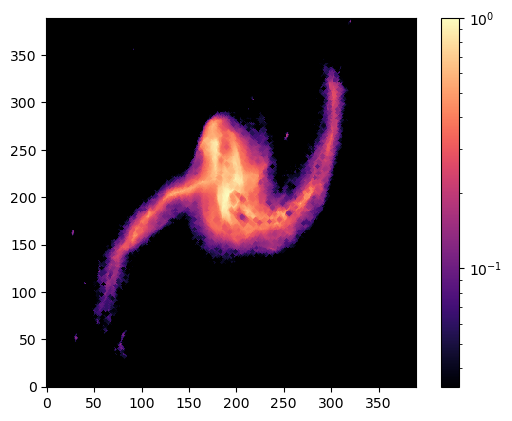

In [7]:
from skimage.transform import rescale
from skimage.morphology import erosion
merger = fits.getdata(os.path.join('data', 'NGC2623.fits'), header=False).astype(float)
merger = merger[100:-20, 20:-100]
merger = rescale(merger, 0.6, anti_aliasing=False)
merger[merger < 0] = 0

# clean small stellar clumps
merger = erosion(erosion(merger))

# we increase the contrast
#merger = np.log10(merger) + 1
#merger[merger < 0] = 0
merger[merger < 3e-2] = 0

# we normalize so that it is
merger /= merger.max()

plt.imshow(merger, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm())
plt.colorbar()
plt.show()

In [8]:
merger_witdh = 2.
merger_pix_scl = merger_witdh / len(merger)
merger_position = (-0.2, 0)
kwargs_merger = {
    'grid_center': merger_position, # in arcsec
    'grid_shape': (merger_witdh, merger_witdh),  # in arcsec
    'pixel_scale_factor': merger_pix_scl / pix_scl,  # in arcsec
}
pprint(kwargs_merger)
source_model_input = LightModel(['PIXELATED'], pixel_interpol='bicubic',
                                kwargs_pixelated=kwargs_merger)
amp_src = 3e-1
kwargs_source_input = [{'pixels': amp_src * merger}]

{'grid_center': (-0.2, 0),
 'grid_shape': (2.0, 2.0),
 'pixel_scale_factor': 0.0641025641025641}


### Generate the lens image

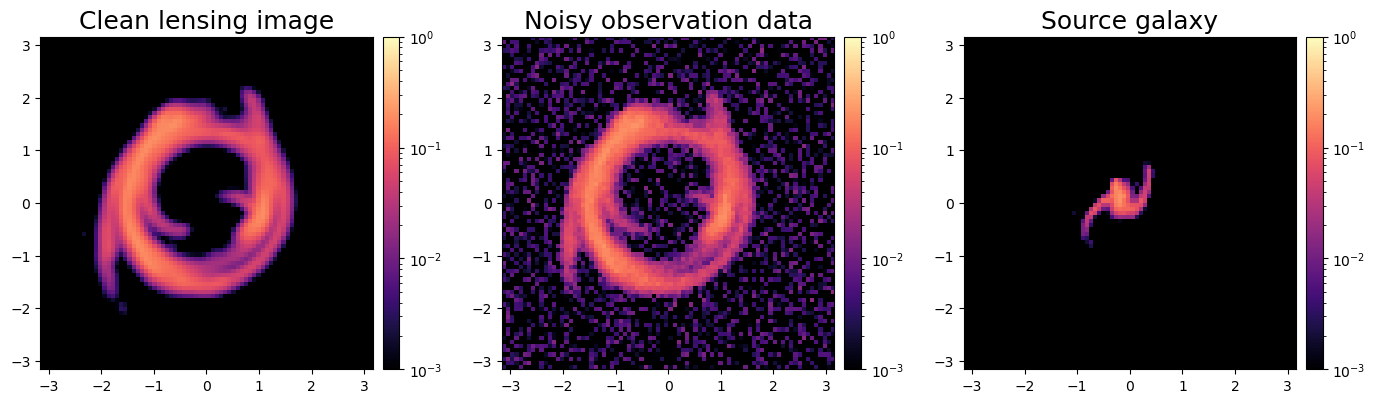

In [9]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_mass_model_class=lens_model_input,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input, 
                        kwargs_lens_light=kwargs_lens_light_input,
                        kwargs_source=kwargs_source_input)
image = lens_image_simu.model(**kwargs_all_input)

data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, noise_seed=29)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
#extent_src = lens_image_simu.SourceModel.pixel_grid.extent

# visualize simulated products
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data", fontsize=FS)
plot_util.nice_colorbar(img2)
img3 = ax3.imshow(source_input, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax3.set_title("Source galaxy", fontsize=FS)
plot_util.nice_colorbar(img3)
fig.tight_layout()
plt.show()

## 2. Pixelated source reconstruction

### Create a model for fitting

In [10]:
# Setup the source model: pixelated on a regular grid
kwargs_pixelated_source = {
    'pixel_scale_factor': 0.66,  # = data pixel size / source pixel size
    'grid_center': merger_position, 
    'grid_shape': (2.1, 2.1), # arcsec
}
source_model = LightModel(['PIXELATED'],
                          kwargs_pixelated=kwargs_pixelated_source)

kwargs_numerics_fit = {'supersampling_factor': 3}
lens_image = LensImage(deepcopy(pixel_grid), psf, noise_class=noise,
                       lens_mass_model_class=lens_model_input,
                       source_model_class=source_model,
                       lens_light_model_class=lens_light_model_input,
                       kwargs_numerics=kwargs_numerics_fit)

source_size = lens_image.SourceModel.pixel_grid.num_pixel
source_shape = lens_image.SourceModel.pixel_grid.num_pixel_axes
print(source_shape, source_size)

(40, 40) 1600


In [11]:
# inform the plotter of the data
plotter.set_data(data)

# inform the plotter about the true source (on the pixelated grid)
x_grid_src, y_grid_src = lens_image.SourceModel.pixel_grid.pixel_coordinates
source_input_fitgrid = lens_image_simu.SourceModel.surface_brightness(x_grid_src, y_grid_src, kwargs_source_input)
source_input_fitgrid *= lens_image.Grid.pixel_area
plotter.set_ref_source(source_input_fitgrid)

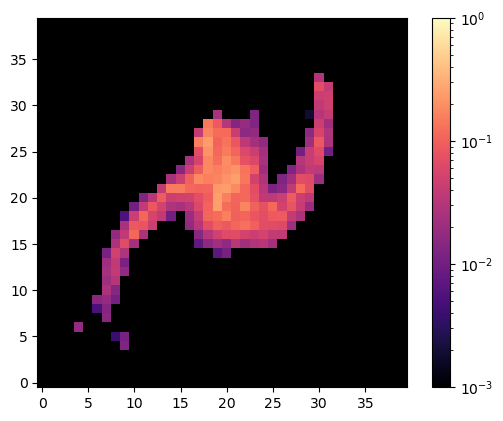

In [12]:
plt.imshow(source_input_fitgrid, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plt.colorbar()
plt.show()

### Setup the regularization strategy, which is a prior on the source surface brigthness

Here we have two ways to impose sparsity in wavelet space for the source pixels, toggled via the variable `SPARSITY_VIA_PRIOR`:
- `False`: the __frequentist way__ (traditional approach): we add a regularization term in the loss function;
- `True`: the __Bayesian way__: we impose a sparsifying prior onto wavelet coefficients of the solution (here via a Laplace prior, but one could also use a Horseshoe prior).

In both approaches, you can choose the regularization strength via `REGUL_STRENGHTS`. These hyperparameters could also be optimitzed, but we don't cover this in this notebook.

As argued in [this article](https://betanalpha.github.io/assets/case_studies/bayes_sparse_regression.html) by M. Betancourt, despite being mathematically very close, the two above approaches are not expected to lead to the same maximum _a posteriori_ solution!

In [13]:
SPARSITY_VIA_PRIOR = True
REGUL_STRENGHTS = (5, 5)  # first scalar is for smaller scale features, second is for the remaining features

### Compute the regularization weights (a.k.a. noise propagation)

In [14]:
# define how to regularize source pixels
regul_model = RegularizationModel([
    ('source', 0, 'SPARSITY_STARLET_2'),  # better results may be obtained with SPARSITY_STARLET (for the frequentist prior approach)
    ('source', 0, 'POSITIVITY'),
])

# initialize the weights based on the previous best fit model
# takes a bit of time, as it samples and propagates noise realizations
noise_var = lens_image.Noise.C_D_model(lens_image.model(**kwargs_all_input))
regul_model.initialize(lens_image, 
                       kwargs_all_input, 
                       noise_var=noise_var, 
                       num_samples=5000)

# retrieve the wavelet transform
starlet = regul_model.method_list[0].transform

# visualize the computed weights
weights_list = regul_model.get_weights()
regul_weights = weights_list[0]
nscales_with_coarse, nxsrc, nysrc = regul_weights.shape
nscales = nscales_with_coarse - 1

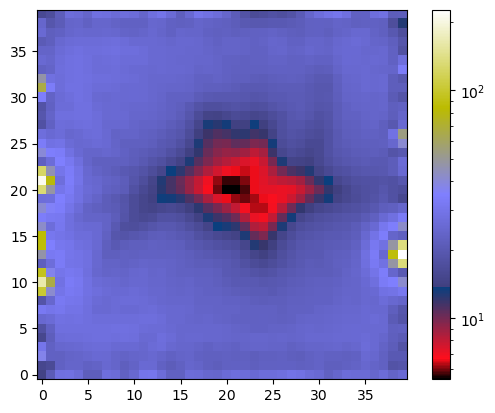

In [15]:
plt.imshow(regul_weights[1], origin='lower', norm=LogNorm(), cmap='gist_stern')
plt.colorbar()
plt.show()

### Create the probabilistic model

In [16]:
class ProbModel(NumpyroModel):
    
    def __init__(self, regul_strengths, sparse_prior_source=True, fix_lens_mass=False):
        self._regul_strengths = regul_strengths
        self._sparse_prior_source = sparse_prior_source
        self._fix_lens_mass = fix_lens_mass
    
    def model(self):
        # pixels of the source
        if self._sparse_prior_source is True:
            # Let's try by sampling directly in wavelet space

            # - detail scales
            lambda0, lambda1 = self._regul_strengths
            lambdas = jnp.array([lambda0] + [lambda1]*(nscales-1))[:, None, None]  # regularization strength
            mu_scales = jnp.zeros((nscales, nxsrc, nysrc))
            b_scales = 1. / (lambdas * regul_weights[:-1])
            dist_scales = dist.Laplace(mu_scales, b_scales)
            source_scales = numpyro.sample('source_scales', dist.Independent(dist_scales, 3))

            # - coarse scale
            source_coarse = numpyro.param('source_coarse', init_value=1e-2*jnp.ones(source_shape), 
                                            constraint=constraints.greater_than(0.), event_dim=source_shape)
            source_pixels = self.coeffs2source(source_scales, source_coarse)

        else:
            # In this case we define the pixels in direct space
            source_pixels = numpyro.param('source_pixels', init_value=1e-2*jnp.ones(source_shape), 
                                          constraint=constraints.greater_than(0.), event_dim=source_shape)
        
        # Parameters of the source
        prior_source = [{'pixels': source_pixels}]

        # Parameters of the lens
        cx = 0. # numpyro.sample('lens_center_x', dist.Normal(0., 0.02))
        cy = 0. # numpyro.sample('lens_center_y', dist.Normal(0., 0.02))
        if self._fix_lens_mass is True:
            prior_lens = kwargs_lens_input
        else:
            prior_lens = [
            {
                # SIE
                'theta_E': numpyro.sample('lens_theta_E', dist.Normal(kwargs_lens_input[0]['theta_E'], 0.1)),
                'e1': numpyro.sample('lens_e1', dist.TruncatedNormal(kwargs_lens_input[0]['e1'], 0.05, low=-0.3, high=0.3)),
                'e2': numpyro.sample('lens_e2', dist.TruncatedNormal(kwargs_lens_input[0]['e2'], 0.05, low=-0.3, high=0.3)),
                'center_x': cx, 
                'center_y': cy
            },
            {
                # external shear
                'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(kwargs_lens_input[1]['gamma1'], 0.05, low=-0.3, high=0.3)), 
                'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(kwargs_lens_input[1]['gamma2'], 0.05, low=-0.3, high=0.3)), 
                'ra_0': 0.0, 'dec_0': 0.0
            }
        ]
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_source=prior_source)
        
        # generates the model image
        model_image = lens_image.model(**model_params)
        
        # estimate the error per pixel
        model_error = jnp.sqrt(noise.C_D_model(model_image))
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_error), 2), obs=data)

        if not self._sparse_prior_source:
            # factors in regularization log-probability
            hyperparams = [
                # NOTE: we could also optimize / infer these hyperparameters
                {'lambda_0': self._regul_strengths[0], 'lambda_1': self._regul_strengths[1]},
                {'strength': 3.},
            ]
            numpyro.factor('source_regul', regul_model.log_prob(model_params, hyperparams))
    
    def coeffs2source(self, source_scales, source_coarse):
        return starlet.reconstruct(jnp.concatenate([source_scales, source_coarse[jnp.newaxis, :, :]], axis=0))

    def params2kwargs(self, params):
        # functions that takes the flattenned dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        if self._sparse_prior_source is True:
            source_pixels = self.coeffs2source(params['source_scales'], params['source_coarse'])
        else:
            source_pixels = params['source_pixels']
        if self._fix_lens_mass is True:
            kwargs_lens = kwargs_lens_input
        else:
            kwargs_lens = [
                {
                    'theta_E': params['lens_theta_E'],
                    'e1': params['lens_e1'],
                    'e2': params['lens_e2'],
                    'center_x': 0., #params['lens_center_x'],
                    'center_y': 0., #params['lens_center_y'],
                },
                {
                    'gamma1': params['lens_gamma1'],
                    'gamma2': params['lens_gamma2'],
                    'ra_0': 0.0, 'dec_0': 0.0
                }
            ] 
        kw = {
            'kwargs_lens': kwargs_lens,
            'kwargs_source': [{'pixels': source_pixels}],
        }
        return kw

Optimizing the lens mass parameters also works fine. However it causes the parameter space to be way too complex for the very basic variational inference (SVI with only Normal distribution guide) run that we performed right after.

In [17]:
prob_model = ProbModel(sparse_prior_source=SPARSITY_VIA_PRIOR, 
                       regul_strengths=REGUL_STRENGHTS,
                       fix_lens_mass=True)

n_param = prob_model.num_parameters
print("Number of parameters:", n_param)

loss = Loss(prob_model)

Number of parameters: 9600


In [18]:
init_params = prob_model.get_sample(seed=0)
kwargs_init = prob_model.params2kwargs(init_params)
#pprint(kwargs_init)

# get initial parameters in uncontrainted space
init_params_unconst = prob_model.unconstrain(init_params)

print("Loss at initial values:", loss(init_params_unconst))

Loss at initial values: 1980.0098


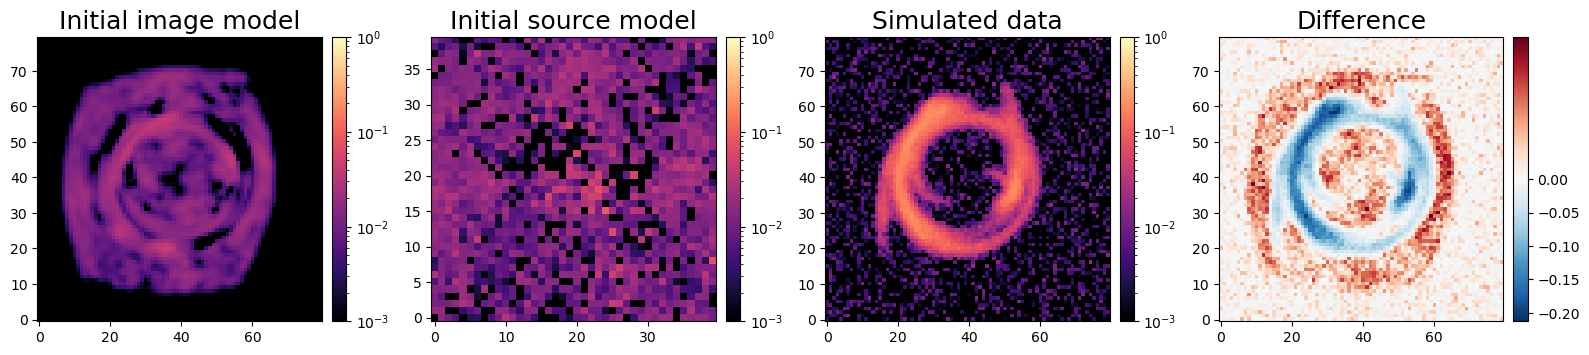

In [19]:
# visualize initial guess
initial_model = lens_image.model(**kwargs_init)
initial_source = lens_image.SourceModel.surface_brightness(x_grid_src, y_grid_src, kwargs_init['kwargs_source']) * lens_image.Grid.pixel_area

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ax = axes[0]
ax.set_title("Initial image model", fontsize=FS)
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Initial source model", fontsize=FS)
im = ax.imshow(initial_source, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Simulated data", fontsize=FS)
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[3]
ax.set_title("Difference", fontsize=FS)
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

### Minimise the loss function using `optax`

We use the adaptive gradient descent algorithm AdaBelief to optimize the values of all source pixels.

In [20]:
optimizer = OptaxOptimizer(loss, loss_norm_optim=data.size)

# optimizer settings
max_iterations = 5000
init_learning_rate = 1e-3

best_fit_unconst, logL, extra_fields, runtime \
    = optimizer.run(init_params_unconst, max_iterations=max_iterations, 
                    init_learning_rate=init_learning_rate)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss(best_fit_unconst))

optax.adabelief: 100%|██████████| 5000/5000 [00:40<00:00, 123.31it/s]


Runtime: 40.56827187538147
Loss at best-fit: -51243.273


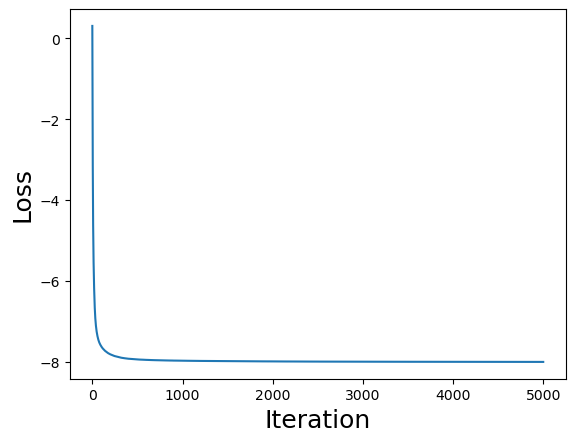

In [21]:
best_fit = prob_model.constrain(best_fit_unconst)
kwargs_bestfit = prob_model.params2kwargs(best_fit)

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

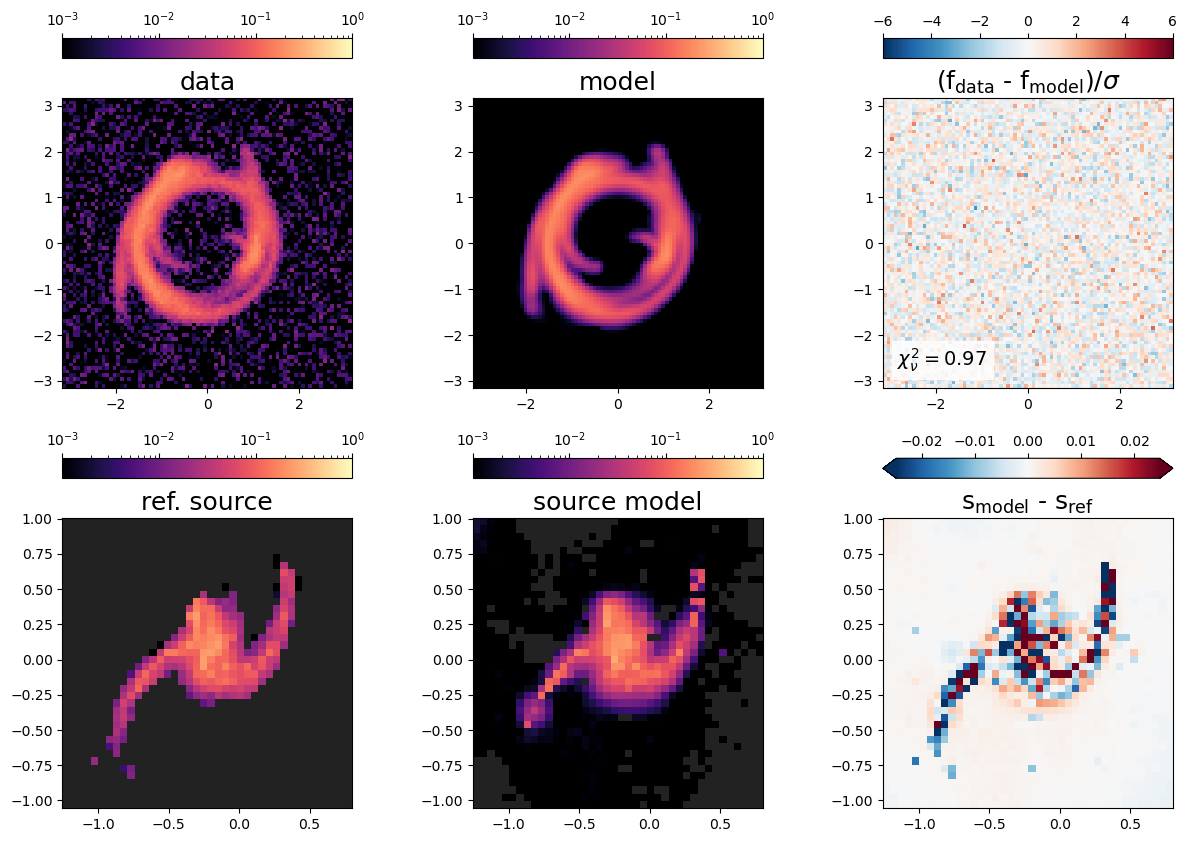

In [22]:
fig = plotter.model_summary(lens_image, kwargs_bestfit)
plt.show()

In [23]:
model_pixels = kwargs_bestfit['kwargs_source'][0]['pixels']
print("min & max source model:", model_pixels.min(), model_pixels.max())

#plt.imshow(model_pixels, norm=Normalize(), cmap=plotter.cmap_flux)
#plt.colorbar()

min & max source model: -0.015663898 0.28453204


In [24]:
pprint(kwargs_lens_input)

[{'center_x': 0.0,
  'center_y': 0.0,
  'e1': Array(0.13732311, dtype=float32, weak_type=True),
  'e2': Array(0.03937677, dtype=float32, weak_type=True),
  'theta_E': 1.4},
 {'dec_0': 0.0,
  'gamma1': Array(-0.00927051, dtype=float32, weak_type=True),
  'gamma2': Array(0.02853169, dtype=float32, weak_type=True),
  'ra_0': 0.0}]


In [25]:
pprint(kwargs_bestfit['kwargs_lens'])

[{'center_x': 0.0,
  'center_y': 0.0,
  'e1': Array(0.13732311, dtype=float32, weak_type=True),
  'e2': Array(0.03937677, dtype=float32, weak_type=True),
  'theta_E': 1.4},
 {'dec_0': 0.0,
  'gamma1': Array(-0.00927051, dtype=float32, weak_type=True),
  'gamma2': Array(0.02853169, dtype=float32, weak_type=True),
  'ra_0': 0.0}]


### Variational inference for a (rough) approximation of the posterior

_Note_: for now this only works when the sparsity is imposed via a Bayesian prior (i.e. `SPARSITY_VIA_PRIOR=True`)

In [26]:
from numpyro.infer.autoguide import AutoNormal

guide = AutoNormal(prob_model.model)

learning_rate = 3e-3
optimizer_vi = numpyro.optim.Adam(learning_rate)

num_iters = 10000

svi = SVI(prob_model.model, guide, optimizer_vi, Trace_ELBO(num_particles=1))
print("Start training guide...")
svi_result = svi.run(jax.random.PRNGKey(1), num_iters)
print("Finish training guide. Extract samples...")

Start training guide...


100%|██████████| 10000/10000 [01:36<00:00, 103.79it/s, init loss: 10815607.0000, avg. loss [9501-10000]: -10650.3213]


Finish training guide. Extract samples...


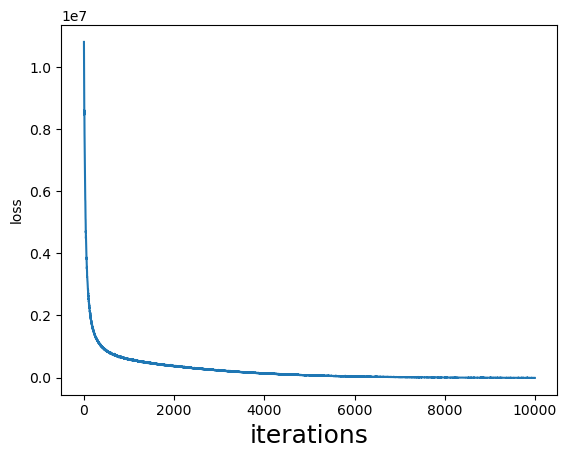

In [27]:
# check convergence
plt.plot(svi_result.losses)
plt.xlabel("iterations", fontsize=18)
plt.ylabel("loss")
plt.show()

In [28]:
num_samples = 5000
posterior_samples = guide.sample_posterior(
    jax.random.PRNGKey(2), svi_result.params, 
    sample_shape=(num_samples,)
)

guide_median = guide.median(svi_result.params)

# you could also sample from the prior for comparison
#prior_samples = prob_model.sample_prior(num_samples, seed=18)

# maximum-a-posterior (MAP) estimate
model_map = kwargs_bestfit['kwargs_source'][0]['pixels']

if 'galaxy_coarse' not in posterior_samples:
    # use the best-fit parameters from the SVI run as the coarse scale when it was not *sampled* (just *optimized*)
    guide_median['source_coarse'] = svi_result.params['source_coarse']
    posterior_samples['source_coarse'] = jnp.repeat(svi_result.params['source_coarse'][None, :, :], num_samples, axis=0)

# median
model_median = prob_model.params2kwargs(guide_median)['kwargs_source'][0]['pixels']

# mean and standard deviation
posterior_images = jax.vmap(prob_model.params2kwargs)(posterior_samples)['kwargs_source'][0]['pixels']
model_mean = np.mean(posterior_images, axis=0)
model_std = np.std(posterior_images, axis=0)

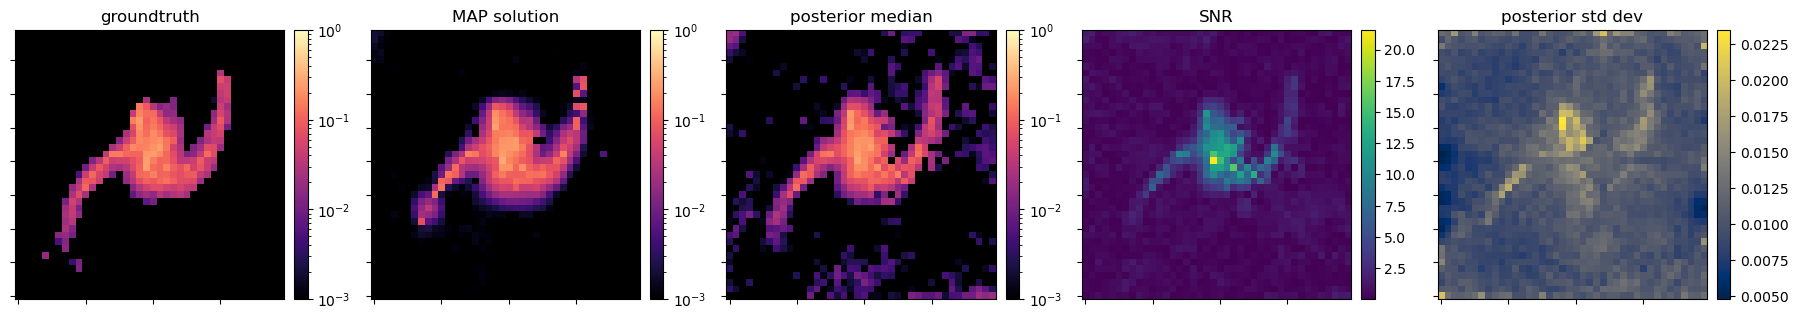

In [29]:
norm = LogNorm(1e-3, 1e0)

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
ax = axes[0]
ax.set_title("groundtruth")
im = ax.imshow(source_input_fitgrid, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[1]
ax.set_title("MAP solution")
im = ax.imshow(model_map, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[2]
ax.set_title("posterior median")
im = ax.imshow(model_median, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[3]
#ax.set_title("posterior mean")
#im = ax.imshow(model_mean, origin='lower', cmap=plotter.cmap_flux, norm=norm)
#plot_util.nice_colorbar(im)
#ax.set_xticklabels([]);ax.set_yticklabels([])
ax.set_title("SNR")
im = ax.imshow(np.abs(model_mean) / model_std, origin='lower', cmap='viridis', norm=Normalize())
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[4]
ax.set_title("posterior std dev")
im = ax.imshow(model_std, origin='lower', cmap='cividis', norm=Normalize())
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

plt.tight_layout()
plt.show()

## 3. What about an analytical+pixelated source model?

Below we try to model the source with a Sérsic profile with pixelated deviations, just like the other notebook is doing for the lens potential. This effectively means that the source has a smooth component (the Sérsic) and various wavelet scales associated, from small details to coarse scales.

This demonstrates the high flexibility of `Herculens`: you can superimpose analytical and pixelated components as you wish!

In [30]:
# Setup the source model: Sersic profile + regular grid of pixels
source_model_hyb = LightModel(['SERSIC_ELLIPSE', 'PIXELATED'],
                              kwargs_pixelated=kwargs_pixelated_source)

kwargs_numerics_fit = {'supersampling_factor': 3}
lens_image_hybrid = LensImage(deepcopy(pixel_grid), psf, noise_class=noise,
                              lens_mass_model_class=lens_model_input,
                              source_model_class=source_model_hyb,
                              lens_light_model_class=lens_light_model_input,
                              kwargs_numerics=kwargs_numerics_fit)

In [31]:
# inform the plotter about the true source (on the pixelated grid)
x_grid_src, y_grid_src = lens_image_hybrid.SourceModel.pixel_grid.pixel_coordinates
source_input_fitgrid = lens_image_simu.SourceModel.surface_brightness(x_grid_src, y_grid_src, kwargs_source_input)
source_input_fitgrid *= lens_image.Grid.pixel_area
plotter.set_ref_source(source_input_fitgrid)

In [32]:
class ProbModelHybridSource(ProbModel):
    
    def model(self):
        
        # pixels of the source
        if self._sparse_prior_source is True:
            # Let's try by sampling directly in wavelet space
            # - detail scales
            lambda0, lambda1 = self._regul_strengths
            lambdas = jnp.array([lambda0] + [lambda1]*(nscales-1))[:, None, None]  # regularization strength
            mu_scales = jnp.zeros((nscales, nxsrc, nysrc))
            b_scales = 1. / (lambdas * regul_weights[:-1])
            dist_scales = dist.Laplace(mu_scales, b_scales)
            source_scales = numpyro.sample('source_scales', dist.Independent(dist_scales, 3))

            # - coarse scale
            source_coarse = numpyro.param('source_coarse', init_value=1e-2*jnp.ones(source_shape), 
                                            constraint=constraints.greater_than(0.), event_dim=source_shape)
            source_pixels = self.coeffs2source(source_scales, source_coarse)
        else:
            source_pixels = numpyro.param('source_pixels', init_value=1e-2*jnp.ones(source_shape), 
                                          constraint=constraints.greater_than(0.), event_dim=source_shape)
            
        source_sersic = {
            'amp': numpyro.sample('source_amp', dist.LogNormal(np.log10(1.), 0.1)),
            'R_sersic': numpyro.sample('source_R_sersic', dist.Uniform(0.0001, 0.5)),
            'n_sersic': numpyro.sample('source_n_sersic', dist.Uniform(0.5, 4.)),
            'e1': numpyro.sample('source_e1', dist.TruncatedNormal(0., 0.05, low=-0.3, high=0.3)),
            'e2': numpyro.sample('source_e2', dist.TruncatedNormal(0., 0.05, low=-0.3, high=0.3)),
            'center_x': numpyro.sample('source_center_x', dist.Normal(merger_position[0], 0.01)),
            'center_y': numpyro.sample('source_center_y', dist.Normal(merger_position[1], 0.01)),
        }
        
        # Parameters of the source
        prior_source = [source_sersic, {'pixels': source_pixels}]

        # Parameters of the lens
        cx = 0. # numpyro.sample('lens_center_x', dist.Normal(0., 0.02))
        cy = 0. # numpyro.sample('lens_center_y', dist.Normal(0., 0.02))
        if self._fix_lens_mass is True:
            prior_lens = kwargs_lens_input
        else:
            prior_lens = [
            {
                # SIE
                'theta_E': numpyro.sample('lens_theta_E', dist.Normal(kwargs_lens_input[0]['theta_E'], 0.1)),
                'e1': numpyro.sample('lens_e1', dist.TruncatedNormal(kwargs_lens_input[0]['e1'], 0.05, low=-0.3, high=0.3)),
                'e2': numpyro.sample('lens_e2', dist.TruncatedNormal(kwargs_lens_input[0]['e2'], 0.05, low=-0.3, high=0.3)),
                'center_x': cx, 
                'center_y': cy
            },
            {
                # external shear
                'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(kwargs_lens_input[1]['gamma1'], 0.05, low=-0.3, high=0.3)), 
                'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(kwargs_lens_input[1]['gamma2'], 0.05, low=-0.3, high=0.3)), 
                'ra_0': 0.0, 'dec_0': 0.0
            }
        ]
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_source=prior_source)
        
        # generates the model image
        model_image = lens_image_hybrid.model(**model_params)
        
        # estimate the error per pixel
        model_error = jnp.sqrt(lens_image_hybrid.Noise.C_D_model(image))
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_error), 2), obs=data)
    
    def params2kwargs(self, params):
        # functions that takes the flattenned dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        if self._sparse_prior_source is True:
            source_pixels = self.coeffs2source(params['source_scales'], params['source_coarse'])
        else:
            source_pixels = params['source_pixels']
        if self._fix_lens_mass is True:
            kwargs_lens = kwargs_lens_input
        else:
            kwargs_lens = [
                {
                    'theta_E': params['lens_theta_E'],
                    'e1': params['lens_e1'],
                    'e2': params['lens_e2'],
                    'center_x': 0., #params['lens_center_x'],
                    'center_y': 0., #params['lens_center_y'],
                },
                {
                    'gamma1': params['lens_gamma1'],
                    'gamma2': params['lens_gamma2'],
                    'ra_0': 0.0, 'dec_0': 0.0
                }
            ] 
        kw = {
            'kwargs_lens': kwargs_lens,
            'kwargs_source': [
                {
                    'amp': params['source_amp'],
                    'R_sersic': params['source_R_sersic'],
                    'n_sersic': params['source_n_sersic'],
                    'e1': params['source_e1'],
                    'e2': params['source_e2'],
                    'center_x': params['source_center_x'],
                    'center_y': params['source_center_y'],
                },
                {'pixels': source_pixels}
            ],
        }
        return kw

In [36]:
prob_model_hybrid = ProbModelHybridSource(regul_strengths=REGUL_STRENGHTS)

n_param = prob_model_hybrid.num_parameters
print("Number of parameters:", n_param)

loss_hybrid = Loss(prob_model_hybrid)

Number of parameters: 9612


Loss at initial values: -4335.9443


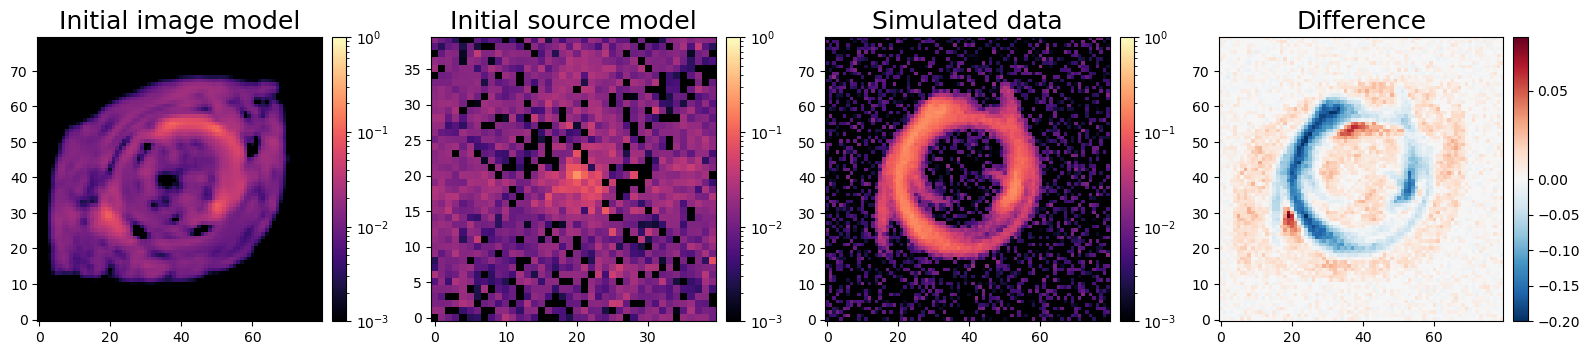

In [37]:
init_params = prob_model_hybrid.get_sample(seed=0)
kwargs_init = prob_model_hybrid.params2kwargs(init_params)
#pprint(kwargs_init)

init_params_unconst = prob_model_hybrid.unconstrain(init_params)
print("Loss at initial values:", loss_hybrid(init_params_unconst))

# visualize initial guess
initial_model = lens_image_hybrid.model(**kwargs_init)
initial_source = lens_image_hybrid.SourceModel.surface_brightness(x_grid_src, y_grid_src, 
                                                                  kwargs_init['kwargs_source'], k=None)
initial_source *= lens_image_hybrid.Grid.pixel_area

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ax = axes[0]
ax.set_title("Initial image model", fontsize=FS)
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Initial source model", fontsize=FS)
im = ax.imshow(initial_source, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Simulated data", fontsize=FS)
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[3]
ax.set_title("Difference", fontsize=FS)
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

In [38]:
optimizer_hyb = OptaxOptimizer(loss_hybrid, loss_norm_optim=data.size)

# optimizer settings
max_iterations = 10000
init_learning_rate = 3e-4

best_fit_hyb_unconst, logL, extra_fields, runtime \
    = optimizer_hyb.run(init_params_unconst, max_iterations=max_iterations, 
                        init_learning_rate=init_learning_rate)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_hybrid(best_fit_hyb_unconst))

optax.adabelief: 100%|██████████| 10000/10000 [01:54<00:00, 87.48it/s]


Runtime: 114.31780982017517
Loss at best-fit: -51361.883


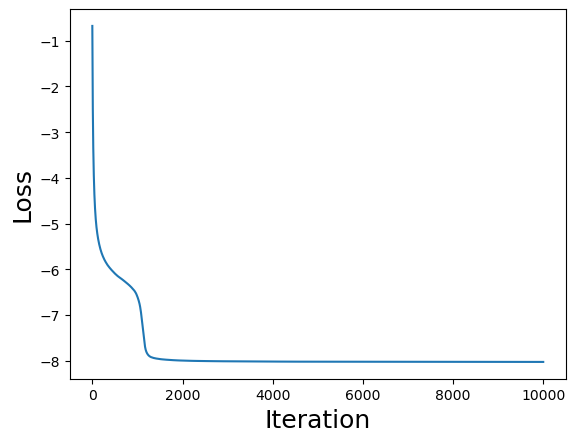

In [39]:
best_fit_hyb = prob_model_hybrid.constrain(best_fit_hyb_unconst)
kwargs_bestfit_hyb = prob_model_hybrid.params2kwargs(best_fit_hyb)

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

_Note: in the plot below, **only the pixelated component** of the source model is shown! Hence the hole in the middle ;)_

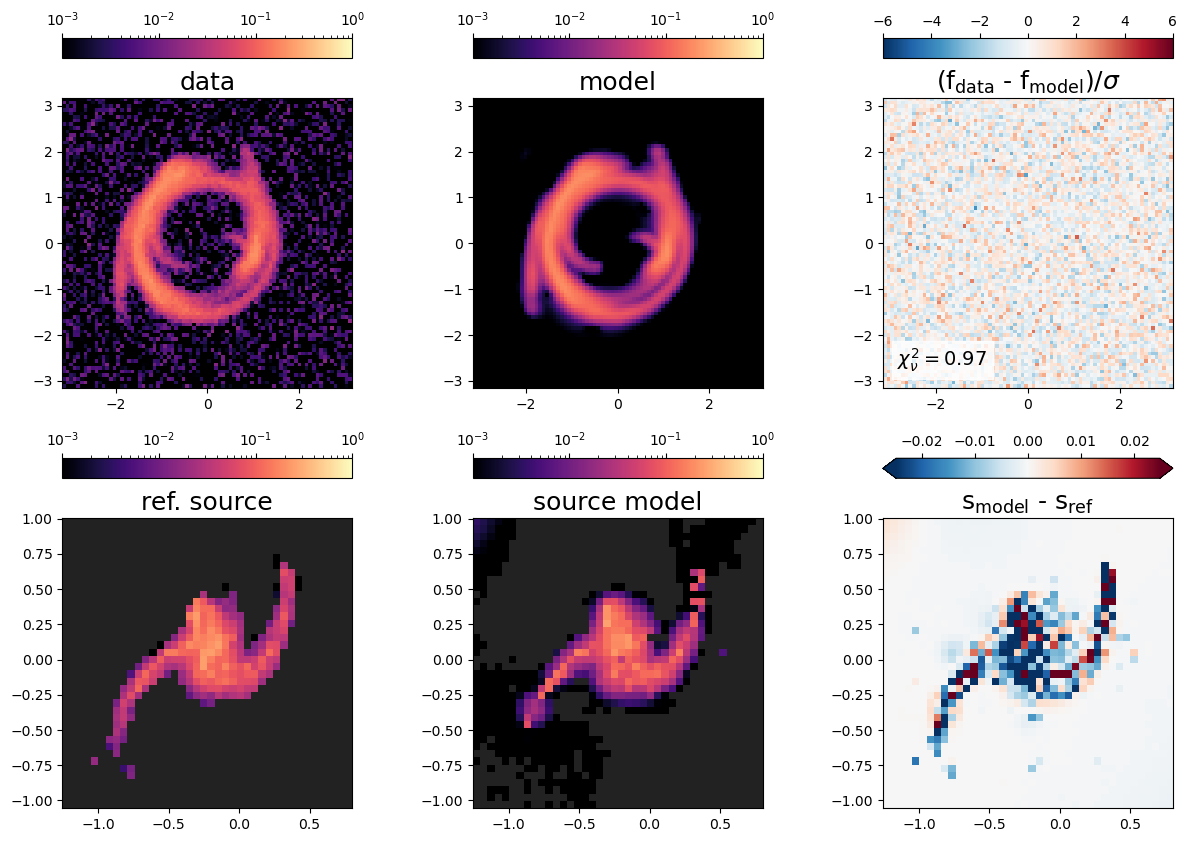

In [40]:
fig = plotter.model_summary(lens_image_hybrid, kwargs_bestfit_hyb)
plt.show()

#### Let's explore the spatial scales of the source model

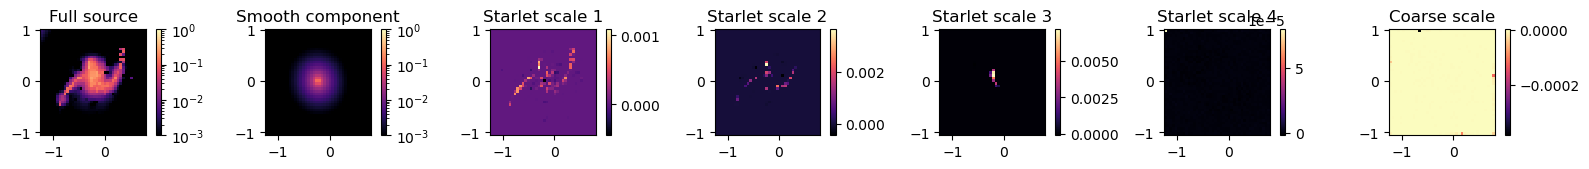

In [42]:
# dissect the various components of the source
def get_source_component(component='pixelated', starlet_scale=None):
    kwargs_src = kwargs_bestfit_hyb['kwargs_source']
    if component == 'smooth':
        k = 0  # 'SERSIC_ELLIPSE'
    elif component == 'pixelated':
        k = 1  # 'PIXELATED'
    else:
        k = None  # all profiles
    
    source_comp = np.array(lens_image_hybrid.SourceModel.surface_brightness(x_grid_src, y_grid_src, kwargs_src, k=k))
    source_comp *= lens_image_hybrid.Grid.pixel_area
    
    # if `re_decompose` is True, takes the above light and compute the corresponding wavelet scales
    # otherwise it will return the actual scales that were optimized
    re_decompose = False
    if isinstance(starlet_scale, int):
        if re_decompose:
            source_comp = np.array(starlet.decompose(source_comp)[starlet_scale])
        else:
            source_comp = best_fit_hyb['source_scales'][starlet_scale] if starlet_scale < nscales else best_fit_hyb['source_coarse']
            source_comp *= lens_image_hybrid.Grid.pixel_area
            
    source_extent = lens_image_hybrid.SourceModel.pixel_grid.extent
    return source_comp, source_extent

num_pixel_scales = nscales
fig, axes = plt.subplots(1, num_pixel_scales+2, figsize=(16, 3))
ax = axes[0]
ax.set_title("Full source")
src_comp, src_extent = get_source_component(component=None)
im = ax.imshow(src_comp, origin='lower', extent=src_extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Smooth component")
src_comp, src_extent = get_source_component(component='smooth')
im = ax.imshow(src_comp, origin='lower', extent=src_extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
plot_util.nice_colorbar(im)
for j in range(0, num_pixel_scales):
    ax = axes[j+2]
    if j < num_pixel_scales-1:
        ax.set_title(f"Starlet scale {j+1}")
    else:
        ax.set_title("Coarse scale")
    src_comp, src_extent = get_source_component(component='pixelated', starlet_scale=j)
    im = ax.imshow(src_comp, origin='lower', extent=src_extent, cmap=plotter.cmap_flux, norm=Normalize())
    plot_util.nice_colorbar(im)

fig.tight_layout()
plt.show()